# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [64]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

Id                                              Title  \
80256  69021388  C Developer Umbraco Sitecore  Coventry up to *...   
98277  69471848                               Technology Developer   
52086  68665038                                    Head of Finance   

                                         FullDescription  \
80256  C Developer Umbraco Sitecore  Coventry up to *...   
98277  An opportunity currently exists for a highly i...   
52086  Head of Finance Central London ****  **** pa A...   

                             LocationRaw LocationNormalized ContractType  \
80256            Coventry, West Midlands           Coventry          NaN   
98277  Abbots Langley Hertfordshire East                 UK          NaN   
52086                     Central London     Central London    full_time   

      ContractTime     Company                  Category            SalaryRaw  \
80256    permanent  CV Bay Ltd                   IT Jobs  27000 - 35000/annum   
98277    permanent         NaN                   IT Jobs                45000   
52086    permanent   ActionAid  Charity & Voluntary Jobs   51,821 - 55,479 pa   

       SalaryNormalized         SourceName  Log1pSalary  
80256             31000   cv-library.co.uk    10.341775  
98277             45000   technojobs.co.uk    10.714440  
52086             53650  Third Sector Jobs    10.890255

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [65]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [66]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [67]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [68]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
#<YOUR CODE HERE>
for col in text_columns:
    for row in data[col].str.split():
        for x in row:
           token_counts[x] += 1
    #data[col].str.split().apply(token_counts)
    #token_counts(data[col].str.split())
    #token_counts.update(data[col].apply(lambda l: tokenizer.tokenize(str(l).lower())))

In [69]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

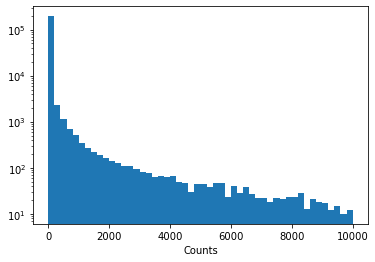

In [70]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [71]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [x for x in token_counts.keys() if token_counts[x] >10 ]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [72]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [73]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [74]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [75]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [76]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 996  176    1    1    1]
 [  18 3461  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [77]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [78]:
#!pip install --upgrade gensim --user

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [79]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [80]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [81]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 286,   88,   11, 4921,   16, 4785],
        [  36,   88,    1,    1,    1,    1],
        [ 101,    4, 3239,  484,   15,  364]]),
 'FullDescription': array([[ 286,   88,   11, 4921,   16,  242, 4785,   59, 2548, 5750],
        [2128, 3171, 2402,  214,   86, 7404,  561, 1948,   57,  833],
        [ 101,    4, 3239,  484,   15,  364,  969, 1164,   74, 1039]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.463132, 10.915107, 10.532123], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [82]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [85]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        #self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX_g)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        #h = F.relu(self.emb(h))
        h = F.relu(self.conv1(h))
        h = self.pool1(h)
        h = self.dense(h)
        
        
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        
        return h

In [86]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [87]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class JobEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(128,32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.conv2 = nn.Conv1d(32 , 64,kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=3)
        self.conv3 = nn.Conv1d(64 , 128,kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=3)
        self.pool4 = GlobalMaxPooling() 
        self.dense = nn.Linear(128, out_size)
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
#         super(self.__class__, self).__init__()
#         self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
#         self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
#         self.pool1 = GlobalMaxPooling()        
#         self.dense = nn.Linear(out_size, out_size)
        
        

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        #print ("input size "  + str(text_ix.size()))
        h = self.emb(text_ix)
        #print ("after empedding "  + str(h.size()))

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        #print ("after transpose "  + str(h.size()))
        h = F.relu(self.conv1(h))
        #print ("after conv1 "  + str(h.size()))
        h = self.pool1(h)
        #print ("after pool1 "  + str(h.size()))
        
        #h = torch.transpose(h, 1, 2)
        
        h = F.relu(self.conv2(h))
        #print ("after conv2 "  + str(h.size()))
        h = self.pool2(h)
        #print ("after pool2 "  + str(h.size()))
        
        h = F.relu(self.conv3(h))
        h = self.pool3(h)
        
        h = self.pool4(h)
        
        h = self.dense(h)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        
        return h

In [88]:
desc_encoder = JobEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [89]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat1 = nn.Linear(n_cat_features, 128)
        self.cat2 = nn.Linear(128, 64)
        self.cat3 = nn.Linear(64, 32)
        #<YOUR CODE>
        
        # define "output" layers that process depend the three encoded vectors into answer
        #<YOUR CODE>
        self.dense_o = nn.Linear(160, 32)
        self.output = nn.Linear(32, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = F.relu(self.cat1(cat_features))
        cat_h = F.relu(self.cat2(cat_h))
        cat_h = F.relu(self.cat3(cat_h))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = F.relu(self.dense_o(joint_h))
        joint_h = self.output(joint_h)
        
        #<YOUR CODE>
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:,0]

In [90]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [91]:
batch = generate_batch(data_train, 32)
title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
print(desc_ix.size())
print(title_ix.size())
print (cat_features.size())

torch.Size([32, 1011])
torch.Size([32, 12])
torch.Size([32, 3768])


In [92]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [93]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [94]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [154]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [155]:
#num_epochs = 100
num_epochs = 30

max_len = 100
batch_size = 32
batches_per_epoch = 100

In [156]:
for epoch_i in range(num_epochs):
    
    print("**********Numbuer " + str(epoch_i))
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

**********Numbuer 0
Training:


C:\Users\User\AppData\Local\Temp/ipykernel_17764/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	12.90148
	MAE:	47269.57104



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35010
	MAE:	5596.80112



**********Numbuer 1
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.29501
	MAE:	5241.20560



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25435
	MAE:	4644.52927



**********Numbuer 2
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23157
	MAE:	4535.24445



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18677
	MAE:	4074.03171



**********Numbuer 3
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18387
	MAE:	4100.52856



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18020
	MAE:	3858.50850



**********Numbuer 4
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17375
	MAE:	3883.41389



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15201
	MAE:	3741.77864



**********Numbuer 5
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15793
	MAE:	3719.59021



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14992
	MAE:	3570.69653



**********Numbuer 6
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14954
	MAE:	3598.09989



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13317
	MAE:	3440.63887



**********Numbuer 7
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13770
	MAE:	3541.92232



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15504
	MAE:	3610.34974



**********Numbuer 8
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13349
	MAE:	3483.55196



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12095
	MAE:	3283.17277



**********Numbuer 9
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13712
	MAE:	3448.37568



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11976
	MAE:	3284.70715



**********Numbuer 10
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12747
	MAE:	3367.81415



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14140
	MAE:	3486.27208



**********Numbuer 11
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12332
	MAE:	3362.43350



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11405
	MAE:	3224.93169



**********Numbuer 12
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12284
	MAE:	3326.08955



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12805
	MAE:	3554.50667



**********Numbuer 13
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11467
	MAE:	3206.60483



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10947
	MAE:	3167.73896



**********Numbuer 14
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13143
	MAE:	3617.27103



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10553
	MAE:	3066.68614



**********Numbuer 15
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10984
	MAE:	3106.36285



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10762
	MAE:	3176.45786



**********Numbuer 16
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11991
	MAE:	3229.06307



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13412
	MAE:	3380.62168



**********Numbuer 17
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12086
	MAE:	3353.83551



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10058
	MAE:	3009.94102



**********Numbuer 18
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12110
	MAE:	3313.02399



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10968
	MAE:	3234.63694



**********Numbuer 19
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14245
	MAE:	3649.18743



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10845
	MAE:	3054.78789



**********Numbuer 20
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11886
	MAE:	3264.99719



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12792
	MAE:	3676.04328



**********Numbuer 21
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11147
	MAE:	3187.99458



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10340
	MAE:	3122.66928



**********Numbuer 22
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11171
	MAE:	3233.77828



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09644
	MAE:	2917.17198



**********Numbuer 23
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10756
	MAE:	3163.50177



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11724
	MAE:	3173.97168



**********Numbuer 24
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11413
	MAE:	3257.18287



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09438
	MAE:	2892.12776



**********Numbuer 25
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11937
	MAE:	3386.43773



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13786
	MAE:	3945.47098



**********Numbuer 26
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11883
	MAE:	3361.22971



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09638
	MAE:	2984.49964



**********Numbuer 27
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09748
	MAE:	2992.54452



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23116
	MAE:	5757.96560



**********Numbuer 28
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11733
	MAE:	3232.23661



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15110
	MAE:	4188.66021



**********Numbuer 29
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11699
	MAE:	3245.17291



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09436
	MAE:	2973.83158





In [157]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


C:\Users\User\AppData\Local\Temp/ipykernel_17764/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09436
	MAE:	2973.83158





In [158]:
#torch.save(model.state_dict(), "First_model")
torch.save(model.state_dict(), "Second_model_added more layers for describtion")

In [159]:
print (model)

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=64, out_features=64, bias=True)
  )
  (desc_encoder): JobEncoder(
    (emb): Embedding(32456, 128, padding_idx=1)
    (conv1): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pool4): GlobalMaxPooling()
    (dense): Linear(in_features=128, out_features=64, bias=True)
  )
  (cat1): Linear(in_features=3768, out_features=128, bias=True)
  (cat

### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

in this homework we improved CNN arch and added multiple Pooling layers and worked on optimizing the training

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=64, out_features=64, bias=True)
  )
  (desc_encoder): JobEncoder(
    (emb): Embedding(32456, 128, padding_idx=1)
    (conv1): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pool4): GlobalMaxPooling()
    (dense): Linear(in_features=128, out_features=64, bias=True)
  )
  (cat1): Linear(in_features=3768, out_features=128, bias=True)
  (cat2): Linear(in_features=128, out_features=64, bias=True)
  (cat3): Linear(in_features=64, out_features=32, bias=True)
  (dense_o): Linear(in_features=160, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

in the following code i tried to implement Googke Word2Vec as a pretrained wieght but the code hasn't been finished yet 

### Google Word2Vec

In [95]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

Id                                  Title  \
30058   68061365  Mechanical Pressure Engineer Surveyor   
232267  72477840                         RGN  Conventry   
165984  71295334                      Secondary Teacher   

                                          FullDescription  \
30058   Overview: A leading engineering inspection org...   
232267  Nurse vacancy – Coventry RGN Fulltime / Part t...   
165984  Secondary Teacher Monarch Education currently ...   

                  LocationRaw LocationNormalized ContractType ContractTime  \
30058                      UK                 UK          NaN    permanent   
232267               Coventry           Coventry    full_time          NaN   
165984  Liverpool, Merseyside          Liverpool          NaN     contract   

                    Company                   Category  \
30058     Pioneer Selection           Engineering Jobs   
232267  The Placement Group  Healthcare & Nursing Jobs   
165984    Monarch Education              Teaching Jobs   

                              SalaryRaw  SalaryNormalized         SourceName  \
30058   From 28,000 to 34,000 per annum             31000      totaljobs.com   
232267                            28000             28000  careerbuilder.com   
165984                   450 - 900/week             32400   cv-library.co.uk   

        Log1pSalary  
30058     10.341775  
232267    10.239996  
165984    10.385944

In [96]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

In [102]:
import gensim

In [103]:
embeddings = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  


In [104]:
print(embeddings)

KeyedVectors<vector_size=300, 3000000 keys>


In [149]:
index_to_key  = embeddings.index_to_key

In [150]:
len(index_to_key)

3000000

In [151]:
UNK_g, PAD_g = "UNK", "PAD"
UNK_IX_g, PAD_IX_g = len(index_to_key) , len(index_to_key)+1

In [152]:
token_to_id_google = model.key_to_index

In [153]:
print(token_to_id_google['london'])

139693


In [165]:
list(embeddings.vectors)

[array([ 1.1291504e-03, -8.9645386e-04,  3.1852722e-04,  1.5335083e-03,
         1.1062622e-03, -1.4038086e-03, -3.0517578e-05, -4.1961670e-04,
        -5.7601929e-04,  1.0757446e-03, -1.0223389e-03, -6.1798096e-04,
        -7.5531006e-04,  1.4038086e-03, -1.6403198e-03, -6.3323975e-04,
         1.6326904e-03, -1.0070801e-03, -1.2664795e-03,  6.5231323e-04,
        -4.1580200e-04, -1.0757446e-03,  1.5258789e-03, -2.7465820e-04,
         1.4019012e-04,  1.5716553e-03,  1.3580322e-03, -8.3160400e-04,
        -1.4038086e-03,  1.5792847e-03,  2.5367737e-04, -7.3242188e-04,
        -1.0538101e-04, -1.1672974e-03,  1.5792847e-03,  6.5612793e-04,
        -6.5994263e-04,  2.9206276e-06,  1.1291504e-03,  4.2724609e-04,
        -3.7002563e-04, -1.1520386e-03,  1.2664795e-03, -3.5166740e-06,
         2.6512146e-04, -4.0245056e-04,  1.4114380e-04, -3.3617020e-05,
         7.5912476e-04, -5.1879883e-04, -7.1048737e-05,  6.0272217e-04,
        -5.0735474e-04, -1.6250610e-03, -4.3678284e-04, -9.91821

In [160]:

weights = torch.FloatTensor(embeddings.vectors) 
embedding = nn.Embedding.from_pretrained(weights)
embedding.requires_grad = False

In [106]:
# def vectorize_sum(text,embedding_dim):
#     """
#     implement a function that converts preprocessed comment to a sum of token vectors
#     """
#     #if isinstance(sequences[0], str):
#      #   sequences = list(map(str.split, sequences))
    
#     #embedding_dim = embeddings.vectors.shape[1]
#     features = np.zeros([embedding_dim], dtype='float32')
    
#     for token in text.split():
#         if token in embeddings.key_to_index:
#             features += embeddings[token]
    
#     #<YOUR CODE>
    
#     return features

In [154]:
def as_matrix_google(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX_g))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id_google.get(word, UNK_IX_g) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix_google(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2673     921    1765 3000001 3000001]
 [  41053    1911 3000001 3000001 3000001]
 [    567  207291     287    4501    4982]]


In [155]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [156]:
def generate_batch_google(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix_google(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [157]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [161]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=300, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()

        #print (self.num_embeddings)
        
        #self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.emb = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings.vectors,))
        self.conv1 = nn.Conv1d( 300,out_channels=64, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(64, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        
        h = torch.transpose(text_ix, 0, 1)
        h = self.conv1(text_ix)
        #h = F.relu(self.emb(h))
        h = F.relu(h)
        h = self.pool1(h)
        h = self.dense(h)
        
        
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        
        return h

In [162]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch_google(data_train, 3)['Title']))
print(dummy_x.size())
dummy_v = title_encoder(dummy_x)



assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

torch.Size([3, 4])


IndexError: index out of range in self

__Task 2.1__ Create description encoder

In [51]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class JobEncoder(nn.Module):
    def __init__(self, n_tokens=len(index_to_key) +2, out_size=64):
        
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX_g)
        self.conv1 = nn.Conv1d(128,32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.conv2 = nn.Conv1d(32 , 64,kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=3)
        self.conv3 = nn.Conv1d(64 , 128,kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=3)
        self.pool4 = GlobalMaxPooling() 
        self.dense = nn.Linear(128, out_size)
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
#         super(self.__class__, self).__init__()
#         self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
#         self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
#         self.pool1 = GlobalMaxPooling()        
#         self.dense = nn.Linear(out_size, out_size)
        
        

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        #print ("input size "  + str(text_ix.size()))
        h = self.emb(text_ix)
        #print ("after empedding "  + str(h.size()))

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        #print ("after transpose "  + str(h.size()))
        h = F.relu(self.conv1(h))
        #print ("after conv1 "  + str(h.size()))
        h = self.pool1(h)
        #print ("after pool1 "  + str(h.size()))
        
        #h = torch.transpose(h, 1, 2)
        
        h = F.relu(self.conv2(h))
        #print ("after conv2 "  + str(h.size()))
        h = self.pool2(h)
        #print ("after pool2 "  + str(h.size()))
        
        h = F.relu(self.conv3(h))
        h = self.pool3(h)
        
        h = self.pool4(h)
        
        h = self.dense(h)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        
        return h

In [53]:
desc_encoder = JobEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch_google(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [54]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(index_to_key) +2, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat1 = nn.Linear(n_cat_features, 128)
        self.cat2 = nn.Linear(128, 64)
        self.cat3 = nn.Linear(64, 32)
        #<YOUR CODE>
        
        # define "output" layers that process depend the three encoded vectors into answer
        #<YOUR CODE>
        self.dense_o = nn.Linear(160, 32)
        self.output = nn.Linear(32, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = F.relu(self.cat1(cat_features))
        cat_h = F.relu(self.cat2(cat_h))
        cat_h = F.relu(self.cat3(cat_h))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = F.relu(self.dense_o(joint_h))
        joint_h = self.output(joint_h)
        
        #<YOUR CODE>
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:,0]

In [55]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

3000001


In [57]:
# test it on one batch

batch = generate_batch_google(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [58]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [59]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [60]:
from tqdm import tnrange
def iterate_minibatches_google(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch_google(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [61]:
#num_epochs = 100
num_epochs = 30

max_len = 100
batch_size = 32
batches_per_epoch = 100

In [62]:
for epoch_i in range(num_epochs):
    
    print("**********Numbuer " + str(epoch_i))
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches_google(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches_google(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

**********Numbuer 0
Training:


C:\Users\User\AppData\Local\Temp/ipykernel_21268/1879747338.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [157]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


C:\Users\User\AppData\Local\Temp/ipykernel_17764/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09436
	MAE:	2973.83158





In [158]:
#torch.save(model.state_dict(), "First_model")
torch.save(model.state_dict(), "Second_model_added more layers for describtion")